<a href="https://colab.research.google.com/github/Gaurav7888/Adversarial-Attacks-and-Defence/blob/main/ImageBasedAttacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install adversarial-robustness-toolbox


In [ ]:
pip install git+https://github.com/nottombrown/imagenet_stubs


In [ ]:
from keras.applications.densenet import DenseNet169, preprocess_input as densenet_preprocess_input 

from keras.preprocessing import image

# Load ART dependencies:
from art.estimators.classification import KerasClassifier

# Attacks 
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod 
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import DeepFool
from art.attacks.evasion import FrameSaliencyAttack
from art.attacks.evasion import HopSkipJump

# Defenses 
from art.defences.preprocessor import SpatialSmoothing
from art.defences.preprocessor import FeatureSqueezing
from art.defences.preprocessor import GaussianAugmentation
from art.defences.preprocessor import LabelSmoothing

# Install ImageNet:
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

In [ ]:
import numpy as np
from datetime import datetime 
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

In [ ]:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

tf.compat.v1.experimental.output_all_intermediates(True) 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import keras.utils as image
images_list = list()
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    images_list.append(im)
    print (image_path)
    if 'gazelle.jpg' in image_path:
        # get unicycle index
        gazelle_idx = i
images = np.array(images_list)

/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/notebook_computer.jpg
/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/manhole_cover.jpg
/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/tractor.jpg
/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/flagpole.jpg
/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/marmoset.jpg
/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/standard_poodle.jpg
/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/rock_crab.jpg
/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/centipede.jpg
/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/mitten.jpg
/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/bagel.jpg
/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/malamute.jpg
/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/gazelle.jpg
/usr/local/lib/python3.9/dist-packages/imagenet_stubs/images/koala.jpg
/usr/local/lib/python3.9/

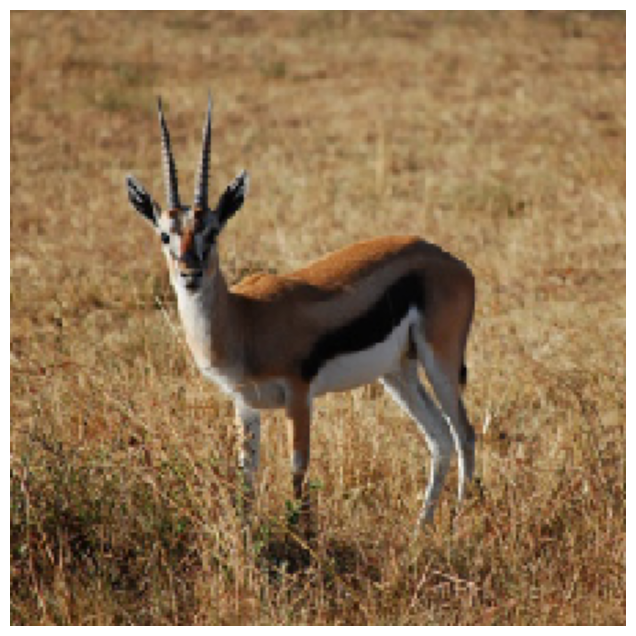

In [ ]:
idx = gazelle_idx

plt.figure(figsize=(8,8)); plt.imshow(images[idx] / 255); plt.axis('off'); plt.show()

In [ ]:
model = DenseNet169(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


58541896/58541896 [==============================] - 1s 0us/step


In [ ]:
x = np.expand_dims(images[idx].copy(), axis=0)
x = densenet_preprocess_input(x)

# Then apply the model, determine the predicted label and confidence:
pred = model.predict(x)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))


Prediction: gazelle - confidence 1.00


In [ ]:
from art.preprocessing.preprocessing import Preprocessor

class DenseNet169Preprocessor(Preprocessor):

    def __call__(self, x, y=None):
        return densenet_preprocess_input(x.copy()), y

    def estimate_gradient(self, x, gradient):
        return gradient[..., ::-1]

In [ ]:
preprocessor = DenseNet169Preprocessor()
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=preprocessor)

In [ ]:
x_art = np.expand_dims(images[idx], axis=0) 

# Then apply the model through the classifier API, determine the predicted label and confidence:
pred = classifier.predict(x_art)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction: gazelle - confidence 1.00


In [ ]:
adv = ProjectedGradientDescent(classifier, targeted=False, max_iter=2, eps_step=1, eps=4)  
# Low max_iter = 2, eps = 4 
# Middle max_iter = 3, eps = 8 
# High max_iter = 10, eps = 8 

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
# plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/2 [00:00<?, ?it/s]

Prediction: impala, Aepyceros melampus - confidence 0.92


In [ ]:
from art.attacks.evasion import FastGradientMethod 

adv = FastGradientMethod(estimator=classifier, eps=5)

x_art_adv = adv.generate(x_art)

pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

Prediction: impala, Aepyceros melampus - confidence 0.63


In [ ]:
from art.attacks.evasion import BasicIterativeMethod 

adv = BasicIterativeMethod(estimator=classifier, targeted=False, eps=5, max_iter=50, eps_step=1)

x_art_adv = adv.generate(x_art)

pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Prediction: impala, Aepyceros melampus - confidence 1.00


In [ ]:
ss = SpatialSmoothing(window_size=3) 

In [ ]:
x_art_def, _ = ss(x_art)
x_art_adv_def, _ = ss(x_art_adv)

In [ ]:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

In [ ]:
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))

Prediction of original sample: gazelle - confidence 1.00
Prediction of adversarial sample: gazelle - confidence 0.90


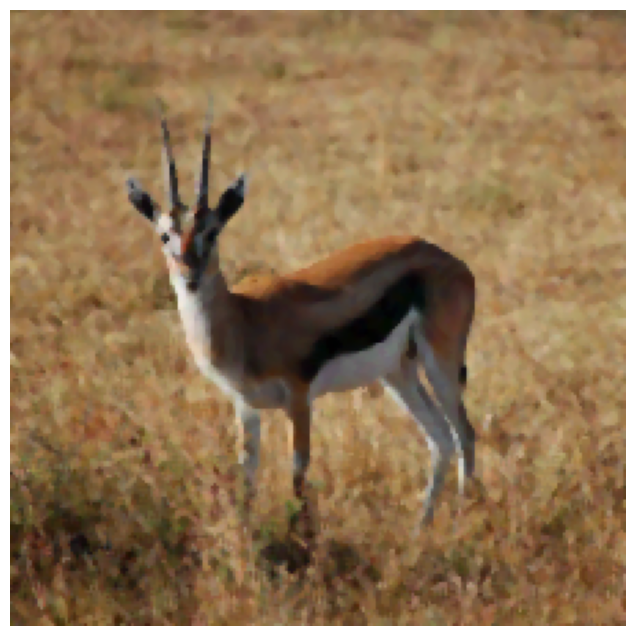

In [ ]:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()


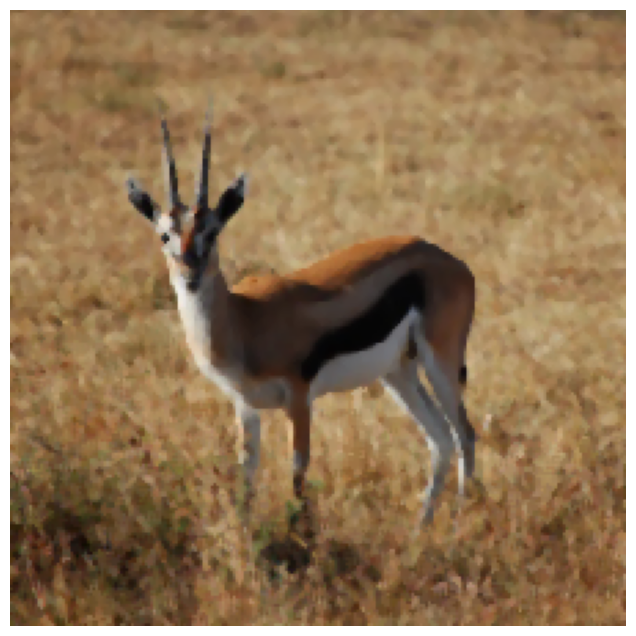

In [ ]:
plt.figure(figsize=(8,8)); plt.imshow(x_art_def[0] / 255); plt.axis('off'); plt.show()


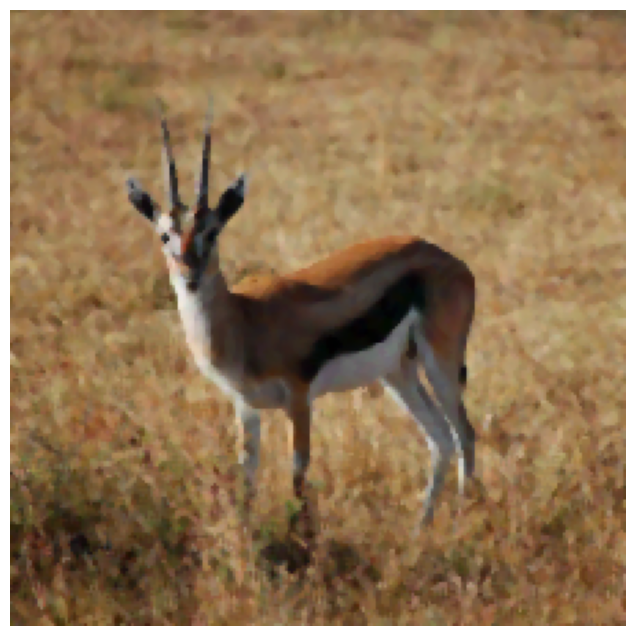

In [ ]:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()


In [ ]:
gda = GaussianAugmentation(sigma=9, augmentation=False)


In [ ]:
x_art_gda_def, _ = gda(x_art)
x_art_adv_gda_def, _ = gda(x_art_adv)

In [ ]:
pred_gda_def = classifier.predict(x_art_gda_def)
label_gda_def = np.argmax(pred_gda_def, axis=1)[0]
confidence_gda_def = pred_gda_def[:, label_gda_def][0]

pred_adv_gda_def = classifier.predict(x_art_adv_gda_def)
label_adv_gda_def = np.argmax(pred_adv_gda_def, axis=1)[0]
confidence_adv_gda_def = pred_adv_gda_def[:, label_adv_gda_def][0]

In [ ]:
print('Prediction of original sample:', label_to_name(label_gda_def), '- confidence {0:.2f}'.format(confidence_gda_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_gda_def), 
      '- confidence {0:.2f}'.format(confidence_adv_gda_def))

Prediction of original sample: gazelle - confidence 1.00
Prediction of adversarial sample: impala, Aepyceros melampus - confidence 0.94


In [ ]:
fs = FeatureSqueezing(bit_depth=3, clip_values=(0, 255))

In [ ]:
x_art_fs_def, _ = fs(x_art)
x_art_adv_fs_def, _ = fs(x_art_adv)

In [ ]:
pred_fs_def = classifier.predict(x_art_fs_def)
label_fs_def = np.argmax(pred_fs_def, axis=1)[0]
confidence_fs_def = pred_fs_def[:, label_fs_def][0]

pred_adv_fs_def = classifier.predict(x_art_adv_fs_def)
label_adv_fs_def = np.argmax(pred_adv_fs_def, axis=1)[0]
confidence_adv_fs_def = pred_adv_fs_def[:, label_adv_fs_def][0]

In [ ]:
print('Prediction of original sample:', label_to_name(label_fs_def), '- confidence {0:.2f}'.format(confidence_fs_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_fs_def), 
      '- confidence {0:.2f}'.format(confidence_adv_fs_def))

Prediction of original sample: gazelle - confidence 1.00
Prediction of adversarial sample: gazelle - confidence 0.79


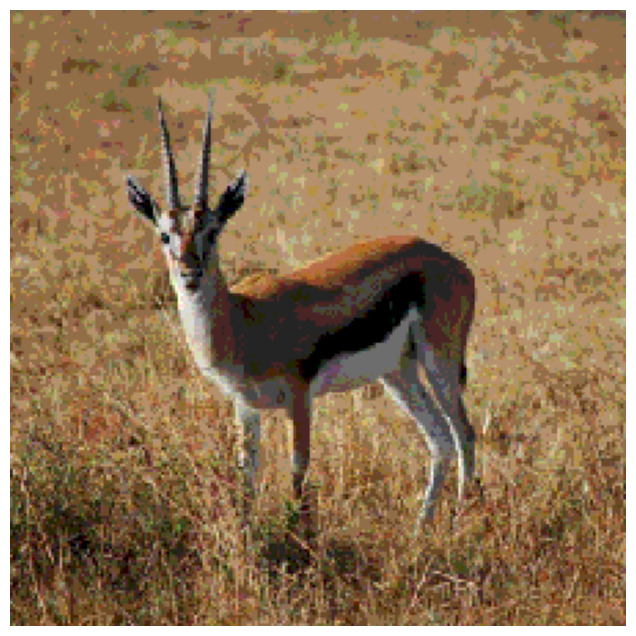

In [ ]:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_fs_def[0] / 255); plt.axis('off'); plt.show()


In [ ]:
fs = FeatureSqueezing(bit_depth=3, clip_values=(0, 255)) # Strength = high 
gda = GaussianAugmentation(sigma=9, augmentation=False) # Strength = high

In [ ]:
x_art_fs_def, _ = fs(x_art)
x_art_fs_gda_def, _ = gda(x_art_fs_def)

x_art_adv_fs_def, _ = fs(x_art_adv)
x_art_adv_fs_gda_def, _ = gda(x_art_adv_fs_def) 

In [ ]:
pred_fs_gda_def = classifier.predict(x_art_fs_gda_def)
label_fs_gda_def = np.argmax(pred_fs_gda_def, axis=1)[0]
confidence_fs_gda_def = pred_fs_gda_def[:, label_fs_gda_def][0]

pred_adv_fs_gda_def = classifier.predict(x_art_adv_fs_gda_def)
label_adv_fs_gda_def = np.argmax(pred_adv_fs_gda_def, axis=1)[0]
confidence_adv_fs_gda_def = pred_adv_fs_gda_def[:, label_adv_fs_gda_def][0]

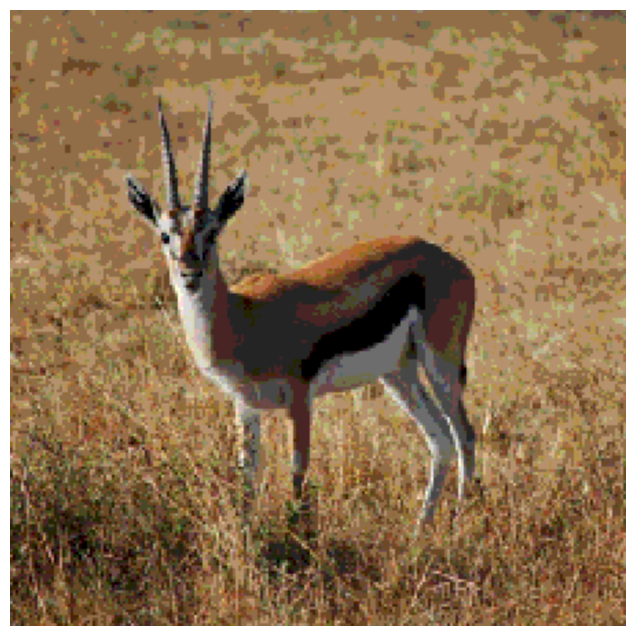

In [ ]:
plt.figure(figsize=(8,8)); plt.imshow(x_art_fs_def[0] / 255); plt.axis('off'); plt.show()


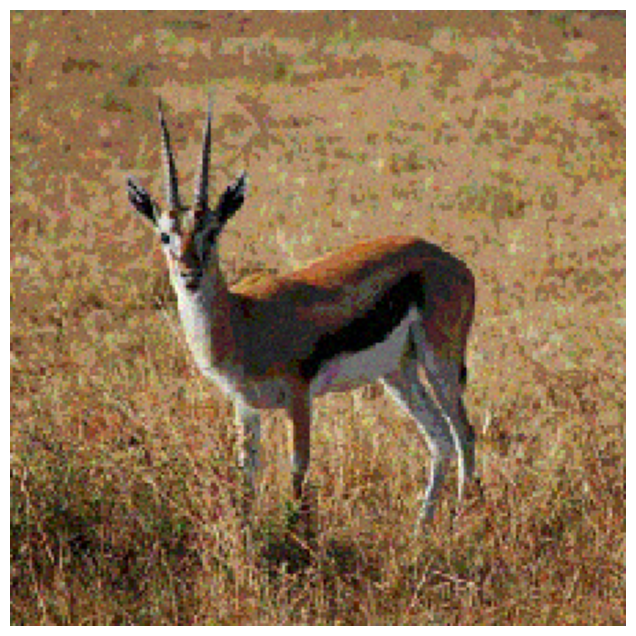

In [ ]:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_fs_gda_def[0] / 255); plt.axis('off'); plt.show()


In [ ]:
print('Prediction of original sample:', label_to_name(label_fs_gda_def), '- confidence {0:.2f}'.format(confidence_fs_gda_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_fs_gda_def), 
      '- confidence {0:.2f}'.format(confidence_adv_fs_gda_def))

Prediction of original sample: gazelle - confidence 1.00
Prediction of adversarial sample: gazelle - confidence 0.87


In [ ]:
gda = GaussianAugmentation(sigma=3, augmentation=False) # Strength = high (sigma=9), middle (sigma=6), low (sigma=3) 
ss = SpatialSmoothing(window_size=5) #

In [ ]:
x_art_ss_def, _ = ss(x_art)
x_art_ss_gda_def, _ = gda(x_art_ss_def)

x_art_adv_ss_def, _ = ss(x_art_adv)
x_art_adv_ss_gda_def, _ = gda(x_art_adv_ss_def)

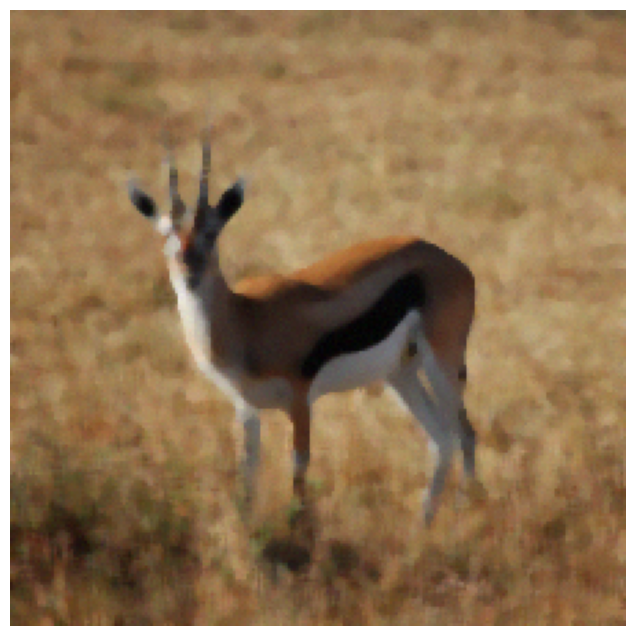

In [ ]:
plt.figure(figsize=(8,8)); plt.imshow(x_art_ss_gda_def[0] / 255); plt.axis('off'); plt.show()


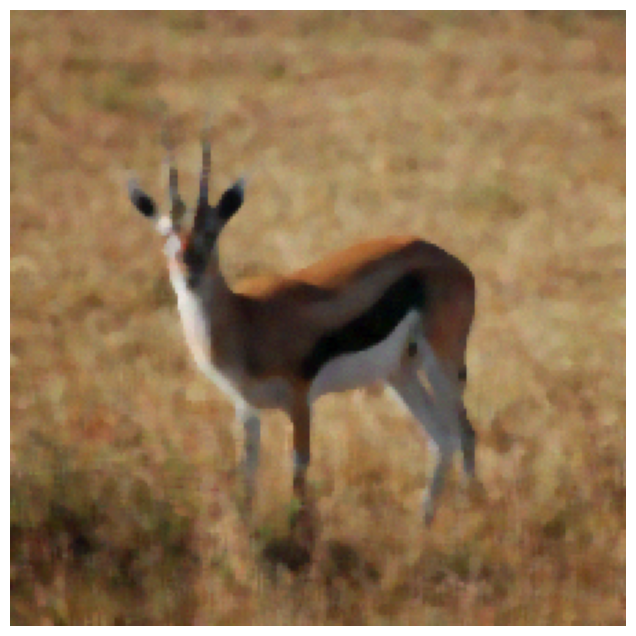

In [ ]:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_ss_gda_def[0] / 255); plt.axis('off'); plt.show()


In [ ]:
pred_ss_gda_def = classifier.predict(x_art_ss_gda_def)
label_ss_gda_def = np.argmax(pred_ss_gda_def, axis=1)[0]
confidence_ss_gda_def = pred_ss_gda_def[:, label_ss_gda_def][0]

pred_adv_ss_gda_def = classifier.predict(x_art_adv_ss_gda_def)
label_adv_ss_gda_def = np.argmax(pred_adv_ss_gda_def, axis=1)[0]
confidence_adv_ss_gda_def = pred_adv_ss_gda_def[:, label_adv_ss_gda_def][0]

In [ ]:
print('Prediction of original sample:', label_to_name(label_ss_gda_def), '- confidence {0:.2f}'.format(confidence_ss_gda_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_ss_gda_def), 
      '- confidence {0:.2f}'.format(confidence_adv_ss_gda_def))

Prediction of original sample: gazelle - confidence 1.00
Prediction of adversarial sample: gazelle - confidence 1.00
